# Atelier 4 : Clustering


L'objectif de cet atelier est de detecter le plagiarisme dans une collection de documents texte en regroupant dans les mêmes clusters les documents texte qui était recopier à partir du même document original.
On va reprendre le même dataset des ateliers 1 et 2.

# 1.	Preparation du DataSet

Écrire le code permettant de récupérer le dataset du plagiarisme traité dans les ateliers précédents et appliquer les prétraitements nécessaires.

In [3]:
import glob
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string, re
import pandas as pd
import numpy as np

path = 'c:/Users/dscon/Documents/COURS UM6P/S3/TEXT-MINING/final_df.csv'
data = pd.read_csv(path)

df_content = data[['User', 'Task', 'UResponse', 'OResponse']]

stop_words = set(stopwords.words('english'))


def get_corpus(text):
    '''Uttiliser la librairie glob pour recuperer les documents dans une
    liste de listes dont les sous listes representent le contenu des documents
    du corpus'''
    '''Appliquer la segmentation, le cleaning et la lemmatisation'''
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df_content['ProcessedUserContent'] = df_content['UResponse'].apply(get_corpus)
df_content['ProcessedOriginalContent'] = df_content['OResponse'].apply(get_corpus)

C:\Users\dscon\AppData\Local\Temp\ipykernel_9352\42808191.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['ProcessedUserContent'] = df_content['UResponse'].apply(get_corpus)
C:\Users\dscon\AppData\Local\Temp\ipykernel_9352\42808191.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['ProcessedOriginalContent'] = df_content['OResponse'].apply(get_corpus)


In [4]:
df_content.head()

,User,Task,UResponse,OResponse,ProcessedUserContent,ProcessedOriginalContent
0,g0pA,a,Inheritance is a basic concept of Object-Orien...,"In object-oriented programming, inheritance is...",inheritance basic concept objectoriented progr...,objectoriented programming inheritance way for...
1,g0pB,a,Inheritance is a basic concept in object orien...,"In object-oriented programming, inheritance is...",inheritance basic concept object oriented prog...,objectoriented programming inheritance way for...
2,g0pC,a,inheritance in object oriented programming is ...,"In object-oriented programming, inheritance is...",inheritance object oriented programming new cl...,objectoriented programming inheritance way for...
3,g0pD,a,Inheritance in object oriented programming is ...,"In object-oriented programming, inheritance is...",inheritance object oriented programming way fo...,objectoriented programming inheritance way for...
4,g0pE,a,"In object-oriented programming, inheritance is...","In object-oriented programming, inheritance is...",objectoriented programming inheritance way for...,objectoriented programming inheritance way for...


# 2. Vectorisation

## 2.1 TF-IDF

Définir le traitement permettant de récupérer la représentation vectorielle TFIDF des différents documents du corpus.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorsTFIDF(corpus_lemetized):
      vectorizer = TfidfVectorizer()
      tfidf_matrix = vectorizer.fit_transform(corpus_lemetized)
      return tfidf_matrix, vectorizer.get_feature_names_out()



## 2.2 SVD

Définir le traitement permettant de récupérer la représentation vectorielle des différents documents du corpus en se basant sur l'approche SVD.

In [6]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


def build_cooccurrence_matrix(corpus, window_size=2):
    tokeniser_corpus = [doc.split() for doc in corpus]
    vocab = list(word for doc in tokeniser_corpus for word in doc)
    vocab_index = {word : i for word, i in enumerate(vocab)}
    vocab_size = len(vocab)
    matrix_cooccurence = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    for doc in tokeniser_corpus:
        for idx, word in enumerate(doc):
            if word in vocab_index:
                word_idx = vocab_index[word]
                start = max(0, idx - window_size)
                end = min(len(word), idx + window_size+1)
                
                for neighbor_idx in range(start, end):
                    neighbor_word = doc[neighbor_idx]
                    if neighbor_word in vocab_index:
                        neighbor_word_idx = vocab_index[neighbor_word]
                        matrix_cooccurence[word_idx, neighbor_word_idx] += 1
            
    return matrix_cooccurence, vocab_index



def docVectSVD(corpus_lemetized, n_components=100, window_size=2):
    
    ''' recuperer le vocabulaire du corpus'''

    ''' creer la matrice des cooccurrences des termes'''

    ''' Appliquer la reduction SVD'''

    ''' genenrer le dictionaire terme/vecteur'''

    ''' Definir les traitement permettant de recuperer la representation
        vectorielle des documents du corpus en se basant sur l'apprche SVD
        (la moyenne des vecteurs composant chaque document).'''
    cooccurrence_matrix, vocab_to_index = build_cooccurrence_matrix(corpus_lemetized, window_size)
    svd = TruncatedSVD(n_components=n_components)
    term_vectors = svd.fit_transform(cooccurrence_matrix)

    index_to_vocab = {idx:word for word, idx in vocab_to_index.items()}
    # term_vector_dict = {index_to_vocab[idx]: term_vectors[idx] for idx in range(len(index_to_vocab))}
    term_vector_dict = {index_to_vocab.get(idx, f"missing_{idx}"): term_vectors[idx] for idx in range(len(term_vectors))}

    doc_vectors = []
    for doc in corpus_lemetized:
        words = doc.split()
        word_vectors = [term_vector_dict[word] for word in words if word in term_vector_dict]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            doc_vector = np.zeros(n_components)
        doc_vectors.append(doc_vector)
        
    return term_vector_dict, doc_vectors



## 2.3 Word2Vec

Definir le traitement permettant de récupérer la representation vectorielle des differents documents du corpus en se basant sur l'approche word2vec.

Tester avec le pretrained glove-wiki-gigaword-50 et avec un apprentissage à partir du corpus.


In [7]:
from gensim.downloader import load

def pretrainedDocWV(corpus_lemetized):
    glove_model = load('glove-wiki-gigaword-50')
    doc_vectors = []
    
    for doc in corpus_lemetized:
        # Tokeniser le document
        words = doc.split()
        word_vectors = [glove_model[word] for word in words if word in glove_model]
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
            doc_vectors.append(doc_vector)
        else:
            doc_vectors.append(np.zeros(glove_model.vector_size))
    return np.array(doc_vectors)


In [8]:
from gensim.models import Word2Vec



def propreDocWV(corpus_lemmatized, vector_size=50, epochs=10):
    ''' Récupérer la représentation vectorielle des documents du corpus 
        en entraînant un modèle Word2Vec sur notre propre corpus.
    '''
    # Tokeniser le corpus pour Word2Vec
    tokenized_corpus = [doc.split() for doc in corpus_lemmatized]
    
    # Créer et entraîner le modèle Word2Vec
    model = Word2Vec(sentences=tokenized_corpus, vector_size=vector_size, window=5, min_count=1, workers=4)
    
    # Initialisation de la liste pour stocker les vecteurs des documents
    doc_vectors = []
    
    for doc in tokenized_corpus:
        # Récupérer les vecteurs pour chaque mot, ignorer les mots absents du vocabulaire
        word_vectors = [model.wv[word] for word in doc if word in model.wv]
        if word_vectors:
            # Calculer la moyenne des vecteurs des mots pour obtenir le vecteur du document
            doc_vector = np.mean(word_vectors, axis=0)
            doc_vectors.append(doc_vector)
        else:
            # En cas d'absence de mots valides, on peut ajouter un vecteur nul ou le gérer autrement
            doc_vectors.append(np.zeros(vector_size))

    return np.array(doc_vectors)

## 2.4 Doc2Vec

Définir le traitement permettant de récupérer la representation vectorielle doc2vec des différents documents du corpus

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def vectorsDoc2Vec(corpus_lemetized):
    ''' Récupérer la représentation vectorielle des documents du corpus en utilisant Doc2Vec '''
    
    # Préparation les données pour Doc2Vec
    tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(corpus_lemetized)]
    
    # modèle Doc2Vec
    model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
    
    # vocabulaire
    model.build_vocab(tagged_data)
    
    # Entrainement du modèle
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    
    # vecteurs de documents
    document_vectors = [model.infer_vector(doc.words) for doc in tagged_data]
    
    return document_vectors


doc_vectors = vectorsDoc2Vec(df_content['ProcessedUserContent'])
doc_vectors



[array([-2.343715  , -0.9948454 , -2.5225084 , -0.15528658,  1.7676123 ,
         0.00728172, -1.1954122 ,  0.49135396, -1.744629  ,  0.78561497,
         2.9492824 , -0.94899577,  2.243611  , -0.0102365 , -1.4285887 ,
        -1.3449317 ,  1.64109   ,  2.0943348 , -2.9938395 ,  0.12612356,
        -0.42483386,  0.7309393 , -1.3151824 ,  0.38280633,  1.2281485 ,
        -1.167423  , -2.4738922 , -1.0679278 , -0.51672924, -0.9612032 ,
         3.24466   ,  0.9757443 , -2.5023875 , -0.16915587, -1.6579506 ,
        -0.24467309,  0.43034902,  0.54944015,  1.3450956 , -0.33704388,
        -0.49215686,  0.5119423 , -0.35477105, -0.656554  , -0.13230675,
        -0.17731312, -0.9783442 ,  0.368524  ,  2.0512288 , -0.77966535],
       dtype=float32),
 array([-1.3385905 ,  0.27787063, -3.3053792 , -0.02436704,  0.08574454,
         1.3567187 ,  1.7302326 ,  0.46448448, -1.3002696 ,  3.32817   ,
         2.5396643 ,  0.7124659 ,  3.581133  , -1.076845  , -1.3038747 ,
        -1.0760766 ,  2.842

# 3. Clustering avec K-means

## 3.1 k-means avec TFIDF

Ci-dessous un exemple d'application du k-means en se basant sur le representation TFIDF.  

In [10]:
#K-MEANS CLUSTERING

#fit(X[, y, sample_weight])          : Compute k-means clustering.
#predict(X[, sample_weight])         : Predict the closest cluster each sample in X belongs to.
#fit_predict(X[, y, sample_weight])  :Compute cluster centers and predict cluster index for each sample.

#fit(X[, y, sample_weight])          : Compute k-means clustering.
#transform(X)                        :Transform X to a cluster-distance space.
#fit_transform(X[, y, sample_weight]):Compute clustering and transform X to cluster-distance space.

#score(X[, y, sample_weight])        : Opposite of the value of X on the K-means objective.

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

#initialisation automatique
#km = KMeans(n_clusters=5, init='k-means++',n_init=50)


#predetermination des centroids
centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=50)
print("Clustering sparse data with %s" % km)


# vect=vectorsTFIDF(get_corpus('/Users/rachad/Desktop/corpus/*'))
vects, feature_names = vectorsTFIDF([" ".join(doc.split()) for doc in df_content['ProcessedUserContent']])
pca = PCA(n_components=2)
reduced_vects = pca.fit_transform(vects.toarray())

km.fit(reduced_vects)
y_means = km.predict(reduced_vects)
print("Cluster assignments:", y_means)



Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=50)


c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=50.
  super()._check_params_vs_input(X, default_n_init=10)


Cluster assignments: [2 2 1 1 1 1 2 1 2 2 1 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 2 3 3 2 3 2 2 3 0 4 4 2 0 0 0 0 0 4 4 0 4 0 4 4 4
 0 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Affichage du cluster de chaque document

In [13]:
dict(zip(np.arange(0,100),y_means[:10]))

{0: 2, 1: 2, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 1, 8: 2, 9: 2}

Le score du modele

In [14]:
#score(X[, y, sample_weight]): Opposite of the value of X on the K-means objective.

km.score(reduced_vects)

-1.2091161826384558

Visialisation des clusters

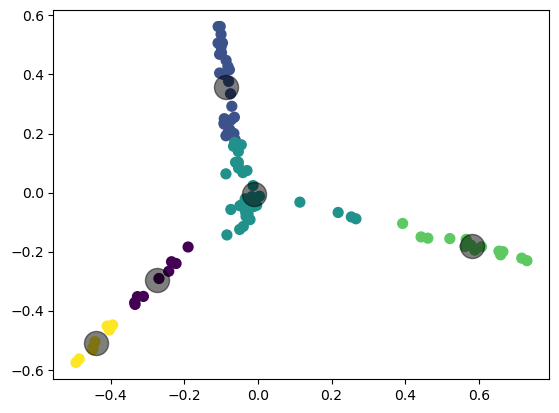

In [15]:
from matplotlib import pyplot as plt
plt.scatter(reduced_vects[:,0],reduced_vects[:,1], c=y_means, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



In [16]:

import numpy as np
cluster_0= [i for i, x in enumerate(y_means) if x == 0]
cluster_1= [i for i, x in enumerate(y_means) if x == 1]
cluster_2= [i for i, x in enumerate(y_means) if x == 2]
cluster_3= [i for i, x in enumerate(y_means) if x == 3]
cluster_4= [i for i, x in enumerate(y_means) if x == 4]


Affichage des clusters

In [14]:
print(type(y_means))
print(cluster_0)
print(cluster_1)
print(cluster_2)
print(cluster_3)
print(cluster_4)

<class 'numpy.ndarray'>
[57, 61, 62, 63, 64, 65, 68, 70, 74]
[2, 3, 4, 5, 7, 10, 11, 14, 16, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
[0, 1, 6, 8, 9, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 49, 52, 54, 55, 60, 75, 79]
[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 53, 56]
[58, 59, 66, 67, 69, 71, 72, 73]


Classer les documents dans chaque cluster en fonction de leurs similarités avec leur centroid (5 classe:....)
Comparer les resultats obtenus avec les annotation preetablies

## 3.2 k-means avec SVD

In [15]:
centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=50)
print("Clustering sparse data with %s" % km)


# vect=vectorsTFIDF(get_corpus('/Users/rachad/Desktop/corpus/*'))
vects_SVD, feature_names_SVD = docVectSVD([" ".join(doc.split()) for doc in df_content['ProcessedUserContent']], n_components=50, window_size=4)
vects_SVD_matrix = np.array(list(vects_SVD.values()), dtype=np.float64)  # Ensure float64
pca = PCA(n_components=2)

reduced_vects_SVD = pca.fit_transform(vects_SVD_matrix)

km.fit(reduced_vects_SVD)
y_means_SVD = km.predict(reduced_vects_SVD)
print("Cluster assignments:", y_means_SVD)

Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=50)
Cluster assignments: [0 0 0 ... 0 0 0]


c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\decomposition\_truncated_svd.py:275: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = exp_var / full_var
c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=50.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


dict : {0: 2, 1: 2, 2: 1, 3: 1, 4: 1, 5: 1, 6: 2, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 2, 13: 2, 14: 1, 15: 2, 16: 1, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2, 37: 2, 38: 3, 39: 3, 40: 3, 41: 3, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 2, 50: 3, 51: 3, 52: 2, 53: 3, 54: 2, 55: 2, 56: 3, 57: 0, 58: 4, 59: 4, 60: 2, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 4, 67: 4, 68: 0, 69: 4, 70: 0, 71: 4, 72: 4, 73: 4, 74: 0, 75: 2, 76: 1, 77: 1, 78: 1, 79: 2, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1}
Score: -0.0


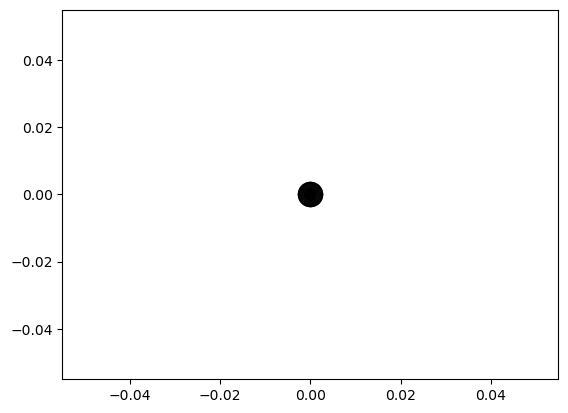

In [16]:
print(f'dict : {dict(zip(np.arange(0,100),y_means))}')

score = km.score(reduced_vects_SVD)
print("Score:", score)

plt.scatter(reduced_vects_SVD[:,0],reduced_vects_SVD[:,1], c=y_means_SVD, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()



## 3.3 k-means avec Word2Vec


**pretrainedDocWV**

Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=50)


c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=50.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster assignments: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2
 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 3 3 4 4 2 3 3 3 3 3 4 4 3 4 3 4 4 4
 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Score: -3.084462097492615


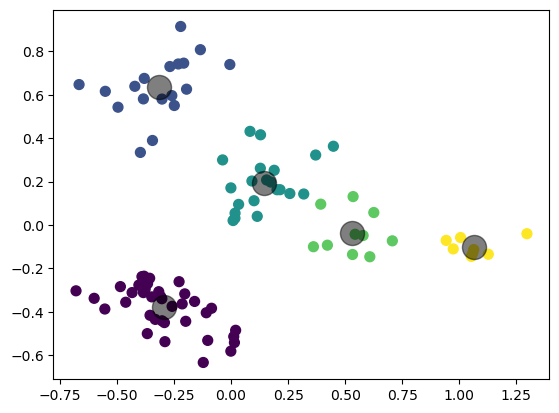

In [17]:
centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=50)
print("Clustering sparse data with %s" % km)


# vect=vectorsTFIDF(get_corpus('/Users/rachad/Desktop/corpus/*'))
vects_DWV = pretrainedDocWV([" ".join(doc.split()) for doc in df_content['ProcessedUserContent']])
vects_DWV_matrix = np.array(list(vects_DWV), dtype=np.float64)  # Ensure float64
pca = PCA(n_components=2)

reduced_vects_DWV = pca.fit_transform(vects_DWV_matrix)

km.fit(reduced_vects_DWV)
y_means_DWV = km.predict(reduced_vects_DWV)
print("Cluster assignments:", y_means_DWV)


score = km.score(reduced_vects_DWV)
print("Score:", score)

plt.scatter(reduced_vects_DWV[:,0],reduced_vects_DWV[:,1], c=y_means_DWV, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()


**propreDocWV**

Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=50)
Cluster assignments: [4 2 2 4 4 4 2 4 2 4 4 2 2 2 4 2 4 2 4 4 4 4 2 4 4 4 4 4 4 4 2 0 2 2 2 4 4
 4 0 0 4 0 0 0 0 0 0 0 0 4 0 0 4 0 2 4 0 4 3 3 2 4 4 0 0 0 3 3 4 3 4 1 3 3
 2 2 0 0 4 2 0 4 4 0 4 0 0 4 4 0 0 0 4 4 2]
Score: -0.018221913539229657


c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=50.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


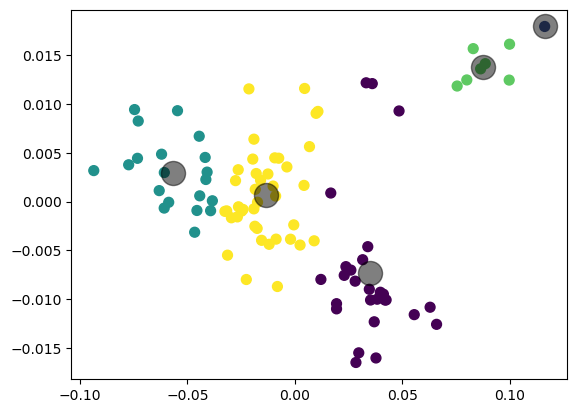

In [18]:
centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=50)
print("Clustering sparse data with %s" % km)


# vect=vectorsTFIDF(get_corpus('/Users/rachad/Desktop/corpus/*'))
vects_PDWV = propreDocWV([" ".join(doc.split()) for doc in df_content['ProcessedUserContent']])
vects_PDWV_matrix = np.array(list(vects_PDWV), dtype=np.float64)  # Ensure float64
pca = PCA(n_components=2)

reduced_vects_PDWV = pca.fit_transform(vects_PDWV_matrix)

km.fit(reduced_vects_PDWV)
y_means_PDWV = km.predict(reduced_vects_PDWV)
print("Cluster assignments:", y_means_PDWV)

score = km.score(reduced_vects_PDWV)
print("Score:", score)

plt.scatter(reduced_vects_PDWV[:,0],reduced_vects_PDWV[:,1], c=y_means_PDWV, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()


## 3.4 k-means avec Doc2Vec

Clustering sparse data with KMeans(init=array([[-0.10512687, -0.35341345],
       [-0.24220548,  0.32397296],
       [-0.03986034,  0.09208828],
       [ 0.72163033,  0.16627089],
       [ 0.72163033,  0.16627089]]),
       n_clusters=5, n_init=50)
Cluster assignments: [1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 0 0 0 2 2 0 0 2 0 0 0 2 0 0 0 0 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 0 0 2 2 2 0 0 0 0 2 0 0 2 2 0 0 2 2]
Score: -126.77455046640674


c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1414: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=50.
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dscon\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


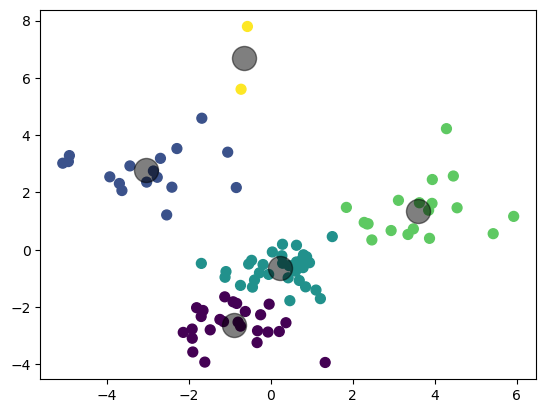

In [19]:

centroids=np.array([[-0.10512687, -0.35341345],[-0.24220548,  0.32397296],[-0.03986034,  0.09208828],[0.72163033, 0.16627089],[0.72163033, 0.16627089]])
km = KMeans(n_clusters=5, init=centroids,n_init=50)
print("Clustering sparse data with %s" % km)


# vect=vectorsTFIDF(get_corpus('/Users/rachad/Desktop/corpus/*'))
vects_D2V = vectorsDoc2Vec([" ".join(doc.split()) for doc in df_content['ProcessedUserContent']])
vects_D2V_matrix = np.array(list(vects_D2V), dtype=np.float64)  # Ensure float64
pca = PCA(n_components=2)

reduced_vects_D2V = pca.fit_transform(vects_D2V_matrix)

km.fit(reduced_vects_D2V)
y_means_D2V = km.predict(reduced_vects_D2V)
print("Cluster assignments:", y_means_D2V)

score = km.score(reduced_vects_D2V)
print("Score:", score)

plt.scatter(reduced_vects_D2V[:,0],reduced_vects_D2V[:,1], c=y_means_D2V, s=50, cmap='viridis')
centers = km.cluster_centers_
plt.scatter(centers[:,0],centers[:,1],c='black',s=300,alpha=0.5);
plt.show()
